In [ ]:
pip install seaborn

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import copy
import os
import zipfile
from google.colab import drive


# --- IMPORTANT: UPDATE THIS PATH ---
# Path to your NEW EXTENDED dataset ZIP file in Google Drive
zip_path = '/content/Hangul Database Extended.zip' # <-- CHANGE THIS
extract_path = '/content/extended_dataset'

# Unzip the dataset
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extended dataset unzipped successfully!")

Extended dataset unzipped successfully!


Using device: cuda
Found 128080 images belonging to 64 classes.

Model Architecture:
KoreanCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim

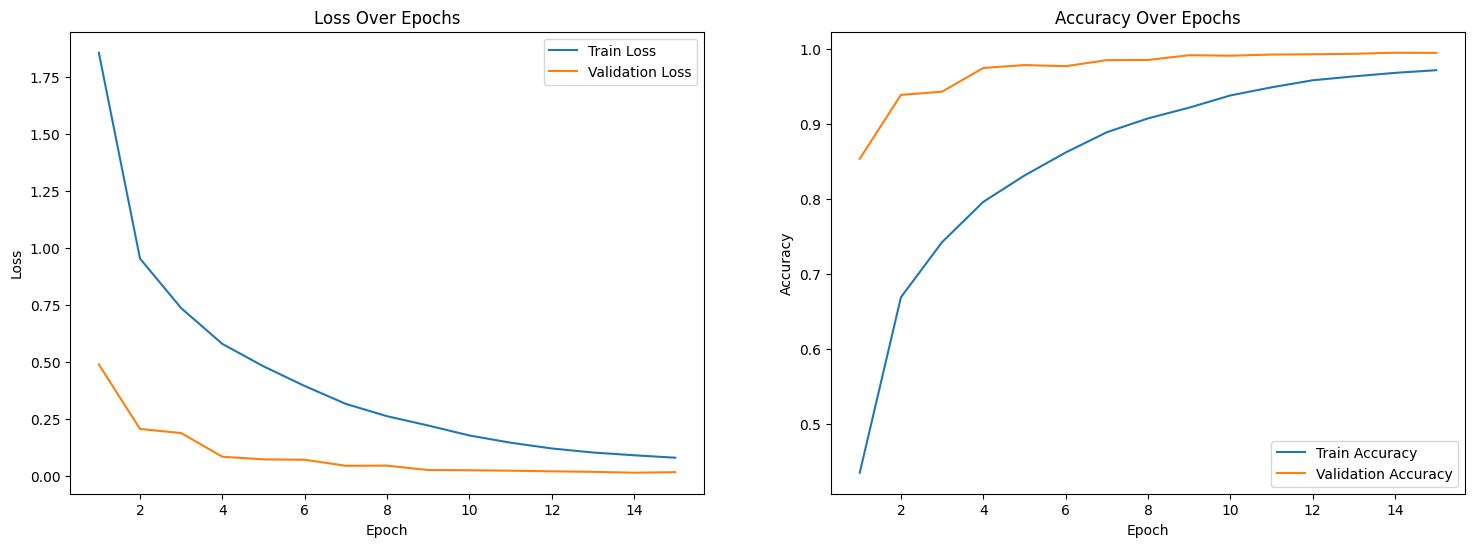


--- Final Model Evaluation ---


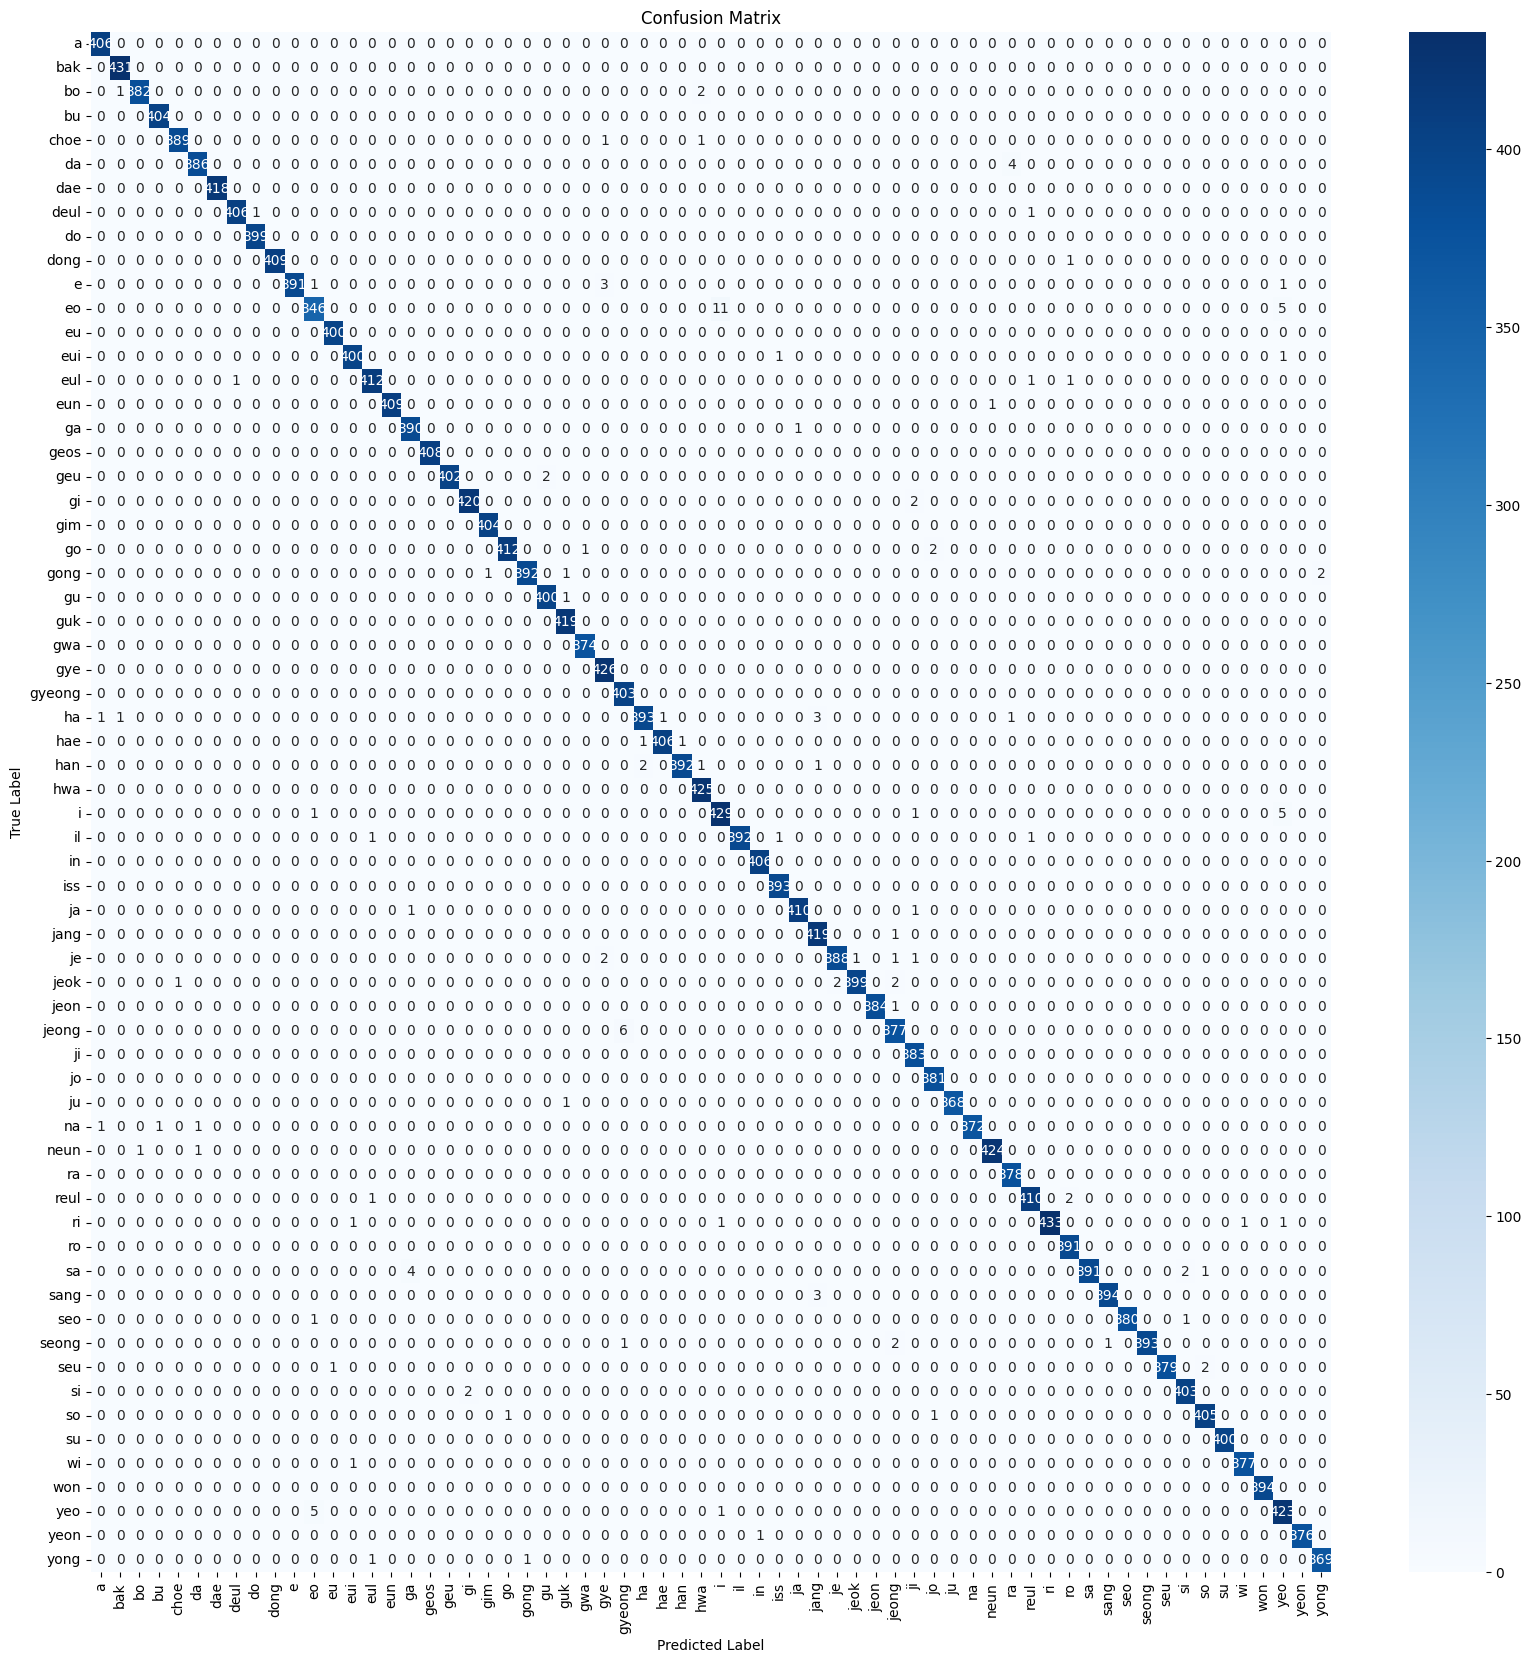


Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00       406
         bak       1.00      1.00      1.00       431
          bo       1.00      0.99      0.99       385
          bu       1.00      1.00      1.00       404
        choe       1.00      0.99      1.00       391
          da       0.99      0.99      0.99       390
         dae       1.00      1.00      1.00       418
        deul       1.00      1.00      1.00       408
          do       1.00      1.00      1.00       399
        dong       1.00      1.00      1.00       410
           e       1.00      0.99      0.99       396
          eo       0.98      0.96      0.97       362
          eu       1.00      1.00      1.00       400
         eui       1.00      1.00      1.00       402
         eul       0.99      0.99      0.99       415
         eun       1.00      1.00      1.00       410
          ga       0.99      1.00      0.99       391
   

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, datasets
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image


# Step 2: Set up device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 3: Define Preprocessing and Data Augmentation
# --- IMPORTANT ---
# Change this path to where your dataset is located in Google Drive
dataset_path = './Hangul Database Extended'

# Define the image transformations for the TRAINING data (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(15),  # Randomly rotate images by +/- 15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10), # Random shifts, scaling, and shearing
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define the image transformations for the VALIDATION/TEST data (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create an ImageFolder dataset. We'll start with the validation transform.
# We will dynamically change the transform before creating DataLoaders.
full_dataset = datasets.ImageFolder(root=dataset_path, transform=val_transform)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Found {len(full_dataset)} images belonging to {num_classes} classes.")

# Step 4: Define the more complex CNN Model (same as before)
class KoreanCNN(nn.Module):
    def __init__(self, num_classes=64):
        super(KoreanCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 64x64 -> 32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 32x32 -> 16x16
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 16x16 -> 8x8
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Print model architecture summary
print("\nModel Architecture:")
model_summary = KoreanCNN(num_classes).to(device)
print(model_summary)

# Step 5: Define Training and Evaluation Loop (same as before)
def train_eval_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        running_loss, correct_preds, total_preds = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += len(inputs)

        epoch_loss = running_loss / total_preds
        epoch_acc = correct_preds.double() / total_preds
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())

        # --- Validation ---
        model.eval()
        running_loss, correct_preds, total_preds = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_preds += torch.sum(preds == labels.data)
                total_preds += len(inputs)

        epoch_val_loss = running_loss / total_preds
        epoch_val_acc = correct_preds.double() / total_preds
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs


# Step 6: 5-Fold Cross-Validation with Augmentation
k_folds = 5
num_epochs = 15 # Increased epochs slightly as augmentation makes training harder
batch_size = 64
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_results = []

print("\n--- Starting 5-Fold Cross-Validation with Augmentation ---")
for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
    print(f"\nFOLD {fold+1}/{k_folds}")

    # Set the correct transform for train and validation sets
    full_dataset.transform = train_transform
    train_sampler = SubsetRandomSampler(train_ids)
    train_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2, pin_memory=True)

    full_dataset.transform = val_transform # Switch to validation transform
    val_sampler = SubsetRandomSampler(val_ids)
    val_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2, pin_memory=True)

    # Initialize model, optimizer, and loss function for each fold
    model = KoreanCNN(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    _, _, _, val_accs = train_eval_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
    fold_results.append(val_accs[-1])


# Calculate and print average accuracy
average_accuracy = np.mean(fold_results)
print(f"\n--- Cross-Validation Complete ---")
print(f"Average Validation Accuracy over {k_folds} folds: {average_accuracy:.4f}")


# Step 7: Final Model Training on the Full Dataset
print("\n--- Training Final Model on Full Dataset with Augmentation ---")
final_model = KoreanCNN(num_classes).to(device)
optimizer = optim.Adam(final_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Create a final train/validation split
train_indices, val_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)

# Create train loader with augmentation
full_dataset.transform = train_transform
train_sampler = SubsetRandomSampler(train_indices)
final_train_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=train_sampler)

# Create validation loader without augmentation
full_dataset.transform = val_transform
val_sampler = SubsetRandomSampler(val_indices)
final_val_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=val_sampler)


# Train the final model
train_losses, val_losses, train_accs, val_accs = train_eval_model(
    final_model, final_train_loader, final_val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Step 8: Plot Loss and Accuracy Curves
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Over Epochs'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Over Epochs'); plt.legend()
plt.show()

# Step 9: Generate and Plot Confusion Matrix and Classification Report
print("\n--- Final Model Evaluation ---")
all_preds, all_labels = [], []
final_model.eval()
with torch.no_grad():
    # Use the validation loader (with no augmentation) for evaluation
    for inputs, labels in final_val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
print(classification_report(all_labels, all_preds, target_names=class_names))

overall_accuracy = report['accuracy']
avg_precision = report['macro avg']['precision']
avg_recall = report['macro avg']['recall']
avg_f1_score = report['macro avg']['f1-score']

print("\nSummary Metrics:")
print("-" * 35)
print(f"| Metric      | Score               |")
print("-" * 35)
print(f"| Precision   | {avg_precision:<19.2f} |")
print(f"| Recall      | {avg_recall:<19.2f} |")
print(f"| F1-Score    | {avg_f1_score:<19.2f} |")
print(f"| Accuracy    | {overall_accuracy:<19.2f} |")
print("-" * 35)


In [90]:
# Step 10: Save the trained model weights
model_save_path = './korean_cnn_augmented_weights_plus_own.pth'
torch.save(final_model.state_dict(), model_save_path)
print(f"\nFinal model weights saved to: {model_save_path}")


Final model weights saved to: ./korean_cnn_augmented_weights_plus_own.pth


# TEST ON OUR OWN DATASET

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, datasets
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

In [92]:
class KoreanCNN(nn.Module):
    def __init__(self, num_classes=64):
        super(KoreanCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 64x64 -> 32x32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 32x32 -> 16x16
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 16x16 -> 8x8
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
dataset_path = './Own Database'

# Define the image transformations for the VALIDATION/TEST data (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

full_dataset = datasets.ImageFolder(root=dataset_path, transform=val_transform)

In [ ]:
dataset_path = './Own Database'


# Define the image transformations for the VALIDATION/TEST data (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create an ImageFolder dataset. We'll start with the validation transform.
# We will dynamically change the transform before creating DataLoaders.
full_dataset = datasets.ImageFolder(root=dataset_path, transform=val_transform)

class_names = full_dataset.classes



# -----------------------------
# Set device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Transforms
# -----------------------------
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# -----------------------------
# Load partial test dataset (e.g., only 8 out of 64 classes)
# -----------------------------
test_dataset = datasets.ImageFolder(
    root="./hangul dataset",  # Only contains folders for 8 letters
    transform=test_transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Get the mapping: folder name → model class index
folder_names = test_dataset.classes  # e.g., ['dae', 'eul', ..., 'yeon']
print("Test folders:", folder_names)

# -----------------------------
# Full label list (used in training)
# -----------------------------
full_class_names = class_names
class_name_to_index = {name: i for i, name in enumerate(full_class_names)}

# Get expected class indices from training model for this test set
expected_model_indices = [class_name_to_index[name] for name in folder_names]

# -----------------------------
# Load trained model
# -----------------------------
model = KoreanCNN()
model.load_state_dict(torch.load("./korean_cnn_augmented_weights_plus_own.pth", map_location=device))
model.eval()
model.to(device)
# -----------------------------
# Evaluation
# -----------------------------
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)

        # Filter model outputs to only the 8 relevant classes
        filtered_outputs = outputs[:, expected_model_indices]
        predicted = torch.argmax(filtered_outputs, dim=1)

        # Now predicted is 0–7, matching label indices from ImageFolder
        correct += (predicted.cpu() == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"✅ Accuracy on subset: {accuracy:.2%}")


Test folders: ['dae', 'eul', 'gong', 'han', 'je', 'neun', 'seong', 'yeon']
✅ Accuracy on subset: 100.00%


C:\Users\Jarvis\AppData\Local\Temp\ipykernel_13240\1117150597.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./korean_cnn_augmented_w

In [95]:
import matplotlib.pyplot as plt
import math

def show_predictions_grid(model, dataloader, expected_model_indices, folder_names, max_images=80, columns=10):
    model.eval()
    images_list = []
    preds_list = []
    true_list = []

    inv_normalize = transforms.Normalize(
        mean=[-0.5 / 0.5], std=[1 / 0.5]
    )

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)

            # Filter to only the used classes
            filtered_outputs = outputs[:, expected_model_indices]
            preds = torch.argmax(filtered_outputs, dim=1)

            for i in range(images.size(0)):
                if len(images_list) >= max_images:
                    break

                img = inv_normalize(images[i].cpu()).squeeze(0)
                images_list.append(img)
                preds_list.append(folder_names[preds[i]])
                true_list.append(folder_names[labels[i]])

            if len(images_list) >= max_images:
                break

    # Plot in grid
    rows = math.ceil(len(images_list) / columns)
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 2, rows * 2))

    for i in range(rows * columns):
        r, c = divmod(i, columns)
        ax = axes[r, c] if rows > 1 else axes[c]
        ax.axis("off")

        if i < len(images_list):
            ax.imshow(images_list[i], cmap="gray")
            correct = preds_list[i] == true_list[i]
            color = "green" if correct else "red"
            ax.set_title(f"P: {preds_list[i]}\nT: {true_list[i]}", 
                         fontsize=10, fontweight='bold', color=color)

    plt.tight_layout()
    plt.show()


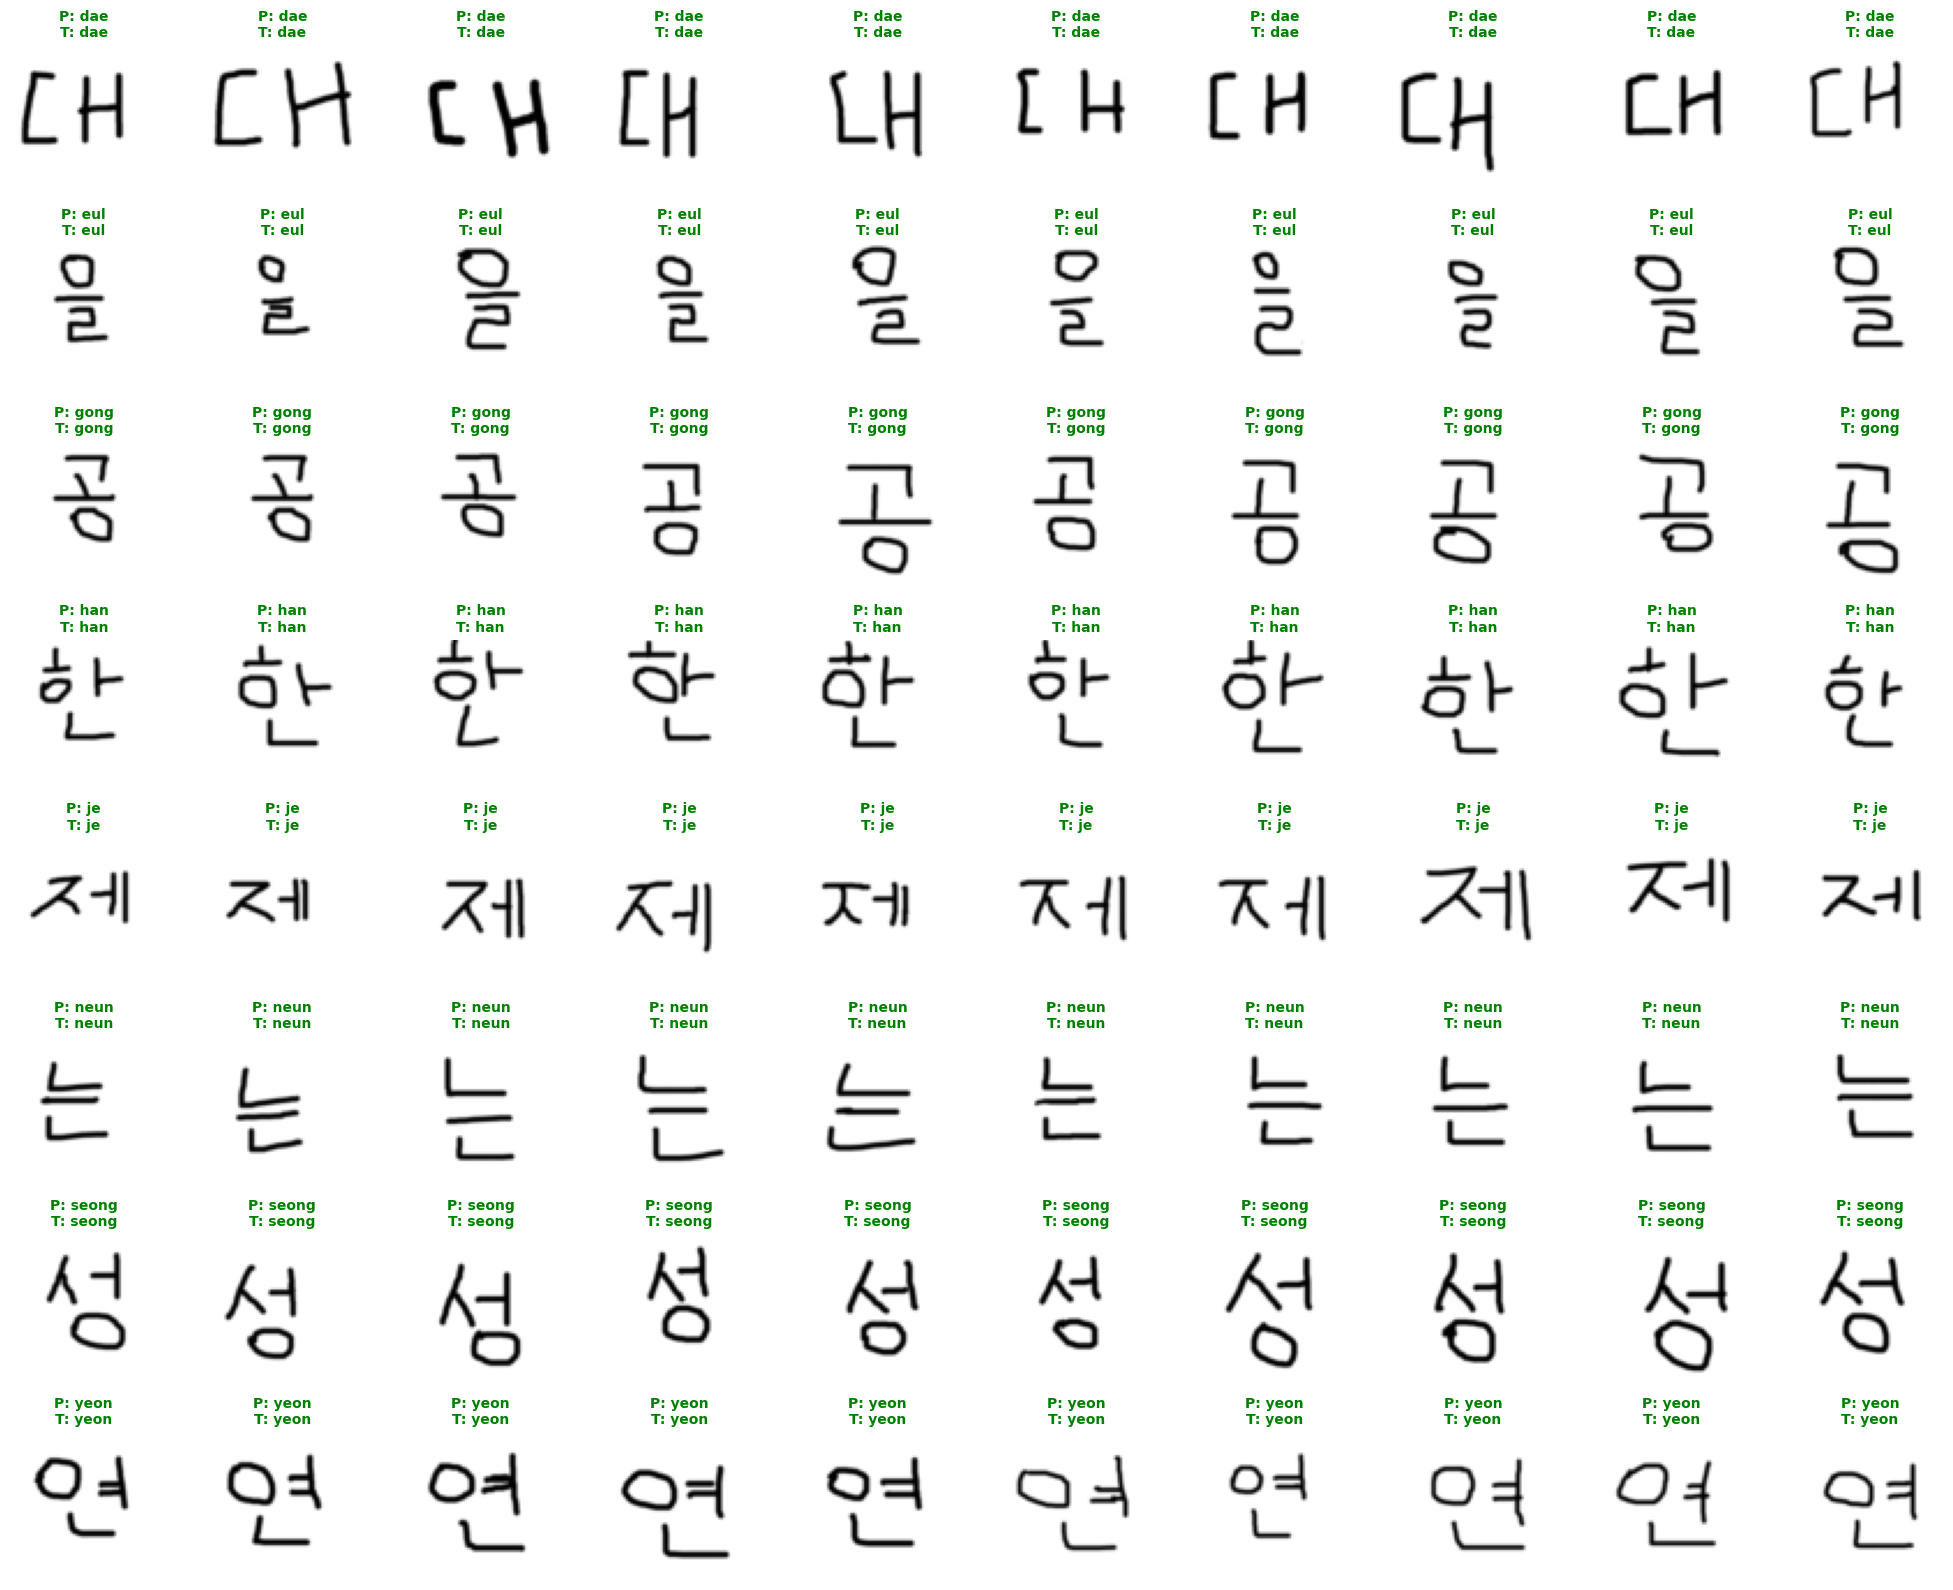

In [96]:
show_predictions_grid(model, test_loader, expected_model_indices, folder_names, max_images=80, columns=10)